#### Web Scraping Mini Project
#### Julia Donato

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re

url = "https://en.wikipedia.org/wiki/Political_party_strength_in_Maryland"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

tables = soup.find_all("table", { "class" : "wikitable" })[:2]  # get only first two tables

all_dataframes = []  # list to store all dataframes

last_electoral_votes = None
last_electoral_votes_party = None

for i, table in enumerate(tables):
    data = []
    skip_gov = 0
    skip_elect = 0
    governor = None
    electoral_votes = None
    electoral_votes_party = None
    row_counter = 0

    rows = table.find_all("tr")
    for row in rows:
        row_counter += 1
        year_cell = row.find("th")

        # Process governor if not in skip mode
        if skip_gov == 0:
            governor_cell = row.find("td")
            if governor_cell:
                governor = governor_cell.get_text(strip=True)
                if governor_cell.has_attr("rowspan"):
                    skip_gov = int(governor_cell["rowspan"])
        
        # Process electoral votes if not in skip mode
        if (i == 0 and row_counter > 15 and skip_elect == 0) or (i == 1 and skip_elect == 0):
            electoral_votes_cell = row.find_all("td")
            if electoral_votes_cell:
                electoral_votes = electoral_votes_cell[-1].get_text(strip=True)
                if electoral_votes_cell[-1].has_attr("rowspan"):
                    skip_elect = int(electoral_votes_cell[-1]["rowspan"])


        if year_cell and governor:
            year = year_cell.get_text(strip=True).split(" ")[0]
            if electoral_votes:  # Ensure that electoral_votes is not None before applying regex
                ec_match = re.search(r"(.+)\(([A-Za-z]+)\)(Y|N)", electoral_votes)
                if ec_match:
                    electoral_votes = ec_match.group(3)
                    electoral_votes_party = ec_match.group(2)
            else:
                electoral_votes_party = None
            data.append([year, governor, electoral_votes, electoral_votes_party])

        # Decrease skip
        if skip_gov > 0:
            skip_gov -= 1
        if skip_elect > 0:
            skip_elect -= 1

        # Store last electoral_votes and electoral_votes_party
        if electoral_votes is not None:
            last_electoral_votes = electoral_votes
            last_electoral_votes_party = electoral_votes_party

    df = pd.DataFrame(data, columns=['Year', 'Governor', 'Electoral College', 'Electoral College Votes Party'])
    if i == 1:
        df = df.drop(0)
    # Drop last two rows- repeat of header
    df.drop(df.tail(2).index,inplace=True)

    # Extract party and clean Governor column
    df['Governor Party'] = df['Governor'].apply(lambda x: re.search('\((.*?)\)', x).group(1) if re.search('\((.*?)\)', x) else '')
    df['Governor'] = df['Governor'].str.replace(r"\(.*\)", "").str.strip()

    all_dataframes.append(df)  # add the dataframe to the list

# Concatenate all the dataframes into one
df = pd.concat(all_dataframes, ignore_index=True)

print(df)

df.to_csv('pres.csv')


     Year        Governor Electoral College Electoral College Votes Party  \
0    1777  Thomas Johnson              None                          None   
1    1778  Thomas Johnson              None                          None   
2    1779  Thomas Johnson              None                          None   
3    1780  Thomas Sim Lee              None                          None   
4    1781  Thomas Sim Lee              None                          None   
..    ...             ...               ...                           ...   
242  2019     Larry Hogan                 N                             D   
243  2020     Larry Hogan                 Y                             D   
244  2021     Larry Hogan                 Y                             D   
245  2022     Larry Hogan                 Y                             D   
246  2023       Wes Moore                 Y                             D   

    Governor Party  
0                I  
1                I  
2           

/var/folders/5p/90fk0v0n54s1q24dvf9zdlgc0000gn/T/ipykernel_66082/3670525268.py:78: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Governor'] = df['Governor'].str.replace(r"\(.*\)", "").str.strip()
/var/folders/5p/90fk0v0n54s1q24dvf9zdlgc0000gn/T/ipykernel_66082/3670525268.py:78: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Governor'] = df['Governor'].str.replace(r"\(.*\)", "").str.strip()


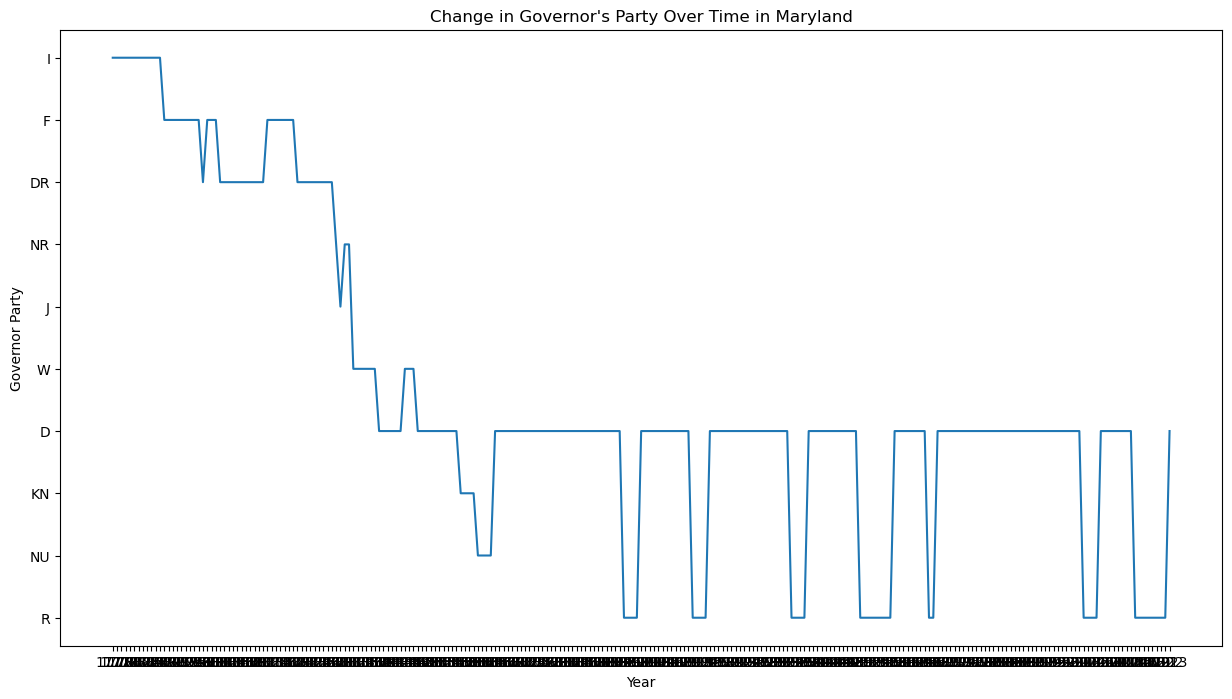

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))
sns.lineplot(data=df, x='Year', y='Governor Party')
plt.title('Change in Governor\'s Party Over Time in Maryland')
plt.show()


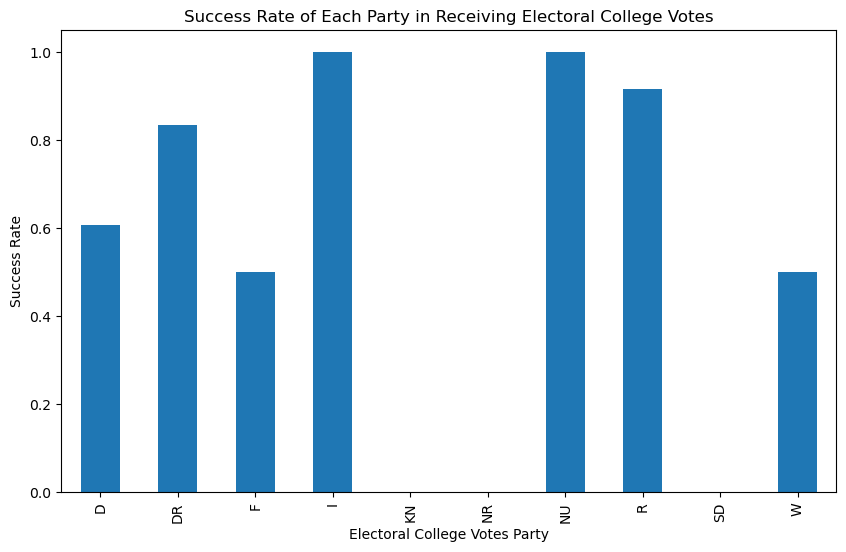

In [4]:
ec_success_rate = df[df['Electoral College'] == 'Y'].groupby('Electoral College Votes Party').size() / df.groupby('Electoral College Votes Party').size()

plt.figure(figsize=(10, 6))
ec_success_rate.plot(kind='bar')
plt.title('Success Rate of Each Party in Receiving Electoral College Votes')
plt.ylabel('Success Rate')
plt.show()


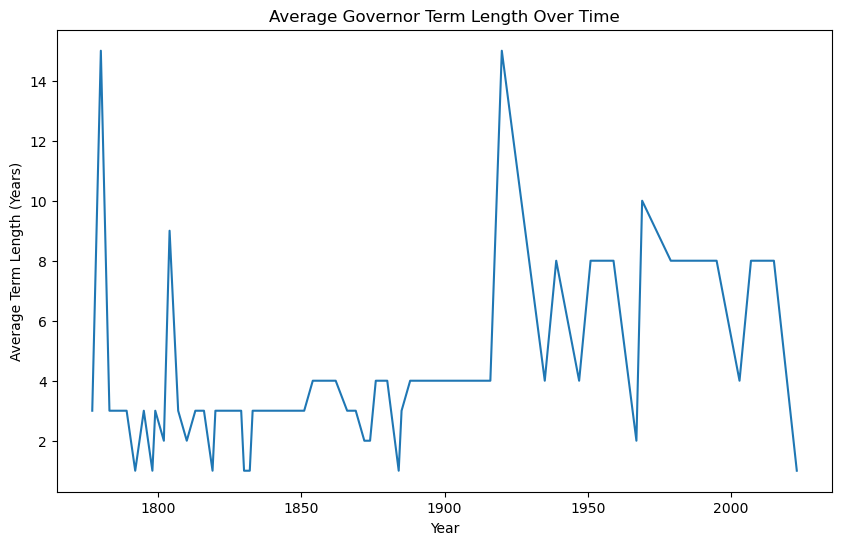

In [5]:
df['Year'] = df['Year'].astype(int)
df['Governor Term Length'] = df.groupby('Governor')['Year'].transform(lambda x: x.max() - x.min() + 1)
average_term_length = df.drop_duplicates('Governor').groupby('Year')['Governor Term Length'].mean()

plt.figure(figsize=(10, 6))
average_term_length.plot(kind='line')
plt.title('Average Governor Term Length Over Time')
plt.ylabel('Average Term Length (Years)')
plt.show()


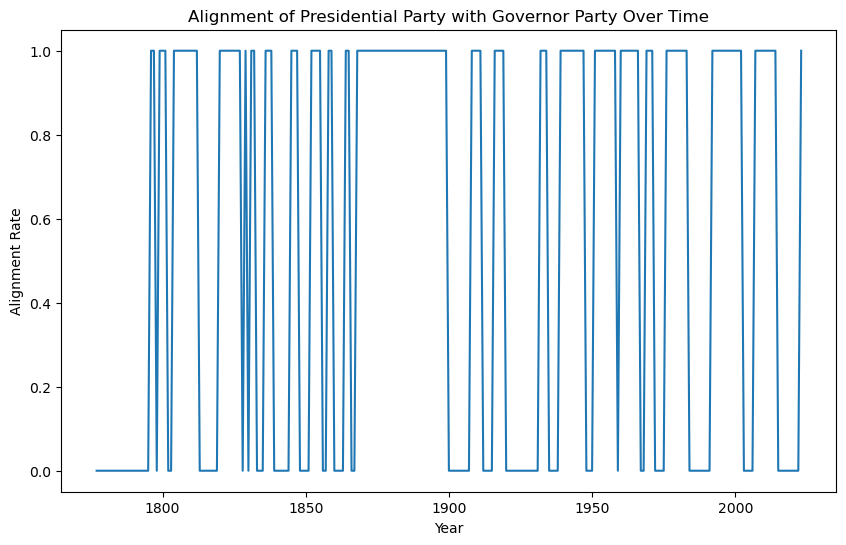

In [7]:
df['Electoral-Gov Alignment'] = df.apply(lambda row: 1 if row['Governor Party'] == row['Electoral College Votes Party'] else 0, axis=1)
alignment_rate = df.groupby('Year')['Electoral-Gov Alignment'].mean()

plt.figure(figsize=(10, 6))
alignment_rate.plot(kind='line')
plt.title('Alignment of Presidential Party with Governor Party Over Time')
plt.ylabel('Alignment Rate')
plt.show()


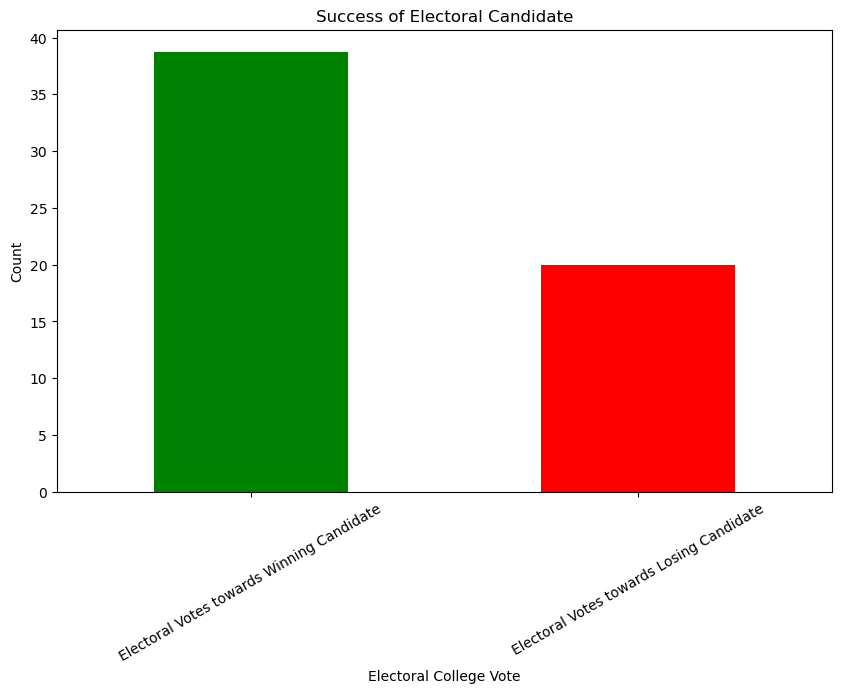

In [10]:
import matplotlib.pyplot as plt

# Count the 'Y' and 'N' in the 'Electoral College' column
electoral_counts = df['Electoral College'].value_counts()/4

# Create a bar chart
plt.figure(figsize=(10, 6))

# Rename the index for visualization
electoral_counts.index = ['Electoral Votes towards Losing Candidate' if i == 'N' else 'Electoral Votes towards Winning Candidate' for i in electoral_counts.index]

electoral_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Success of Electoral Candidate')
plt.ylabel('Count')
plt.xlabel('Electoral College Vote')
plt.xticks(rotation=30)

plt.show()
